# tension_time_evolution

> Evolve tension in time

Simulate time evolution of tension triangulation, so far without reference to real space. Ensure flatness at every step using fake energy minimization.

See lattice model simulation notebooks.

# To Do: Rewrite triangle area minimization with JAX instead of autograd

In [ ]:
#| default_exp tension

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

import sys
from copy import deepcopy

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

## Time evolution in a single triangle

In [ ]:
#| export

# basic formulas for triangles

def vectors_angle(a,b):
    """Angle between two vectors"""
    inner = (a@b)/sqrt((a@a)*(b@b))
    return arccos(inner)

def sides_area(Ts):
    """Triangle area from side lengths"""
    Ts = np.sort(Ts, axis=0)[::-1]
    #A = sqrt((Ts[0]+Ts[1]+Ts[2])*(-Ts[0]+Ts[1]+Ts[2])*(Ts[0]-Ts[1]+Ts[2])*(Ts[0]+Ts[1]-Ts[2]))/4
    A = (Ts[0]+(Ts[1]+Ts[2]))*(Ts[2]-(Ts[0]-Ts[1]))*(Ts[2]+(Ts[0]-Ts[1]))*(Ts[0]+(Ts[1]-Ts[2]))/16
    return sqrt(np.clip(A, 0, np.inf))

def sides_circum(Ts):
    """Triangle circumcircle from side lengths"""
    R = np.prod(Ts, axis=0)/(4*sides_area(Ts))
    return R

def sides_angles(Ts):
    """Triangle angles from side lengths. Sorted so that angle [i] is opposite to Ts[i]"""
    R = sides_circum(Ts)
    inds = np.argmax(Ts, axis=0)
    # need to take the smaller two angles so as to avoid error in arcsin for angles >90
    phis = np.arcsin(Ts/(2*R))
    if isinstance(inds, np.ndarray):
        phis[inds, np.arange(len(inds))] = pi-(phis.sum(axis=0)-phis[inds, np.arange(len(inds))])
    else:
        phis[inds] =  pi-(phis.sum(axis=0)-phis[inds])
    return phis

def angles_shape(phis):
    """Shape order parameter from angles"""
    alpha, beta, gamma = phis
    x = sqrt(3)*sin(alpha)*sin(alpha+2*beta)
    y = (cos(alpha)*cos(alpha+2*beta) - cos(2*alpha))
    psi = np.arctan2(x, y) + pi

    Psi = 6+2*(cos(4*triangle)-cos(2*triangle) - cos(2*(triangle-np.roll(triangle, 1, axis=0)))).sum(axis=0)
    Psi /= (3-cos(2*triangle).sum(axis=0))**2
    Psi = np.sqrt(Psi)
    
    psi_tilde = pi - np.abs((3*psi) % (2*pi) - pi)
    
    return np.array([psi_tilde, Psi])

In [ ]:
round(sides_area([1, 1, sqrt(2)]), ndigits=3) == 1/2

True

In [ ]:
round(sides_circum([sqrt(3), sqrt(3), sqrt(3)]), ndigits=3) == 1

True

In [ ]:
np.round(sides_angles(np.array([1, 1, 1]))*180/pi) == 60

array([ True,  True,  True])

In [ ]:
#| export
def sides_area_jac(Ts):
    """get jacobian of area change in edge length"""
    dA = np.array([0., 0., 0.])
    dA += np.array([1, 1, 1])   * (Ts[2]-(Ts[0]-Ts[1])) * (Ts[2]+(Ts[0]-Ts[1])) * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * np.array([-1, 1, 1])  * (Ts[2]+(Ts[0]-Ts[1])) * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * (Ts[2]-(Ts[0]-Ts[1])) * np.array([1, -1, 1])  * (Ts[0]+(Ts[1]-Ts[2]))
    dA += (Ts[0]+(Ts[1]+Ts[2])) * (Ts[2]-(Ts[0]-Ts[1])) * (Ts[2]+(Ts[0]-Ts[1])) * np.array([1, 1, -1])

    dA /= 32*(sides_area(Ts)+1e-5)  # I think it should be 32 not 48.
    return dA

In [ ]:
Ts = np.array([.4, .5, .6])
dTs = np.array([0, 0, -.2])

areas = [round(x, ndigits=3)
         for x in [sides_area(Ts), sides_area(Ts+dTs), sides_area(Ts)+sides_area_jac(Ts).dot(dTs)]]

print(areas)
#assert areas[1] == areas[2]  # to reasonable precision

[0.099, 0.078, 0.092]


In [ ]:
#| export

# tension time evolution in triangle with constrained area
# perimeter and circumcircle constraints work poorly

def excitable_dt(Ts, m=2):
    """Time derivative of tensions under excitable tension model with constrained area"""
    dT_dt = Ts**m
    area_jac = sides_area_jac(Ts)
    area_jac /= norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)
    return dT_dt

In [ ]:
Ts = np.array([.7, 1.3, sqrt(2)])
dt = .02
dTs = excitable_dt(Ts) * dt

areas = [round(x, ndigits=2) for x in [sides_area(Ts), sides_area(Ts+dTs)]]
print(areas)
assert areas[0] == areas[1]  # to reasonable precision, areas don't change

[0.45, 0.45]


## To Do:

- add `rest` (length) and `flipped` attributes to the `HalfEdge` class -> Done
- remove Edge class? Not really required if we simulate based on half edges -> Done
- add method to compute lengths, angles of `HalfEdges` in `HalfEdgeMesh` -> Done

## ODE integrator

Need to make my own little ODE solver because between ODE steps, we will need to find the real space tessellation. 

Se Numerical Recipes Chpt. 17. 

In [ ]:
## scipy ODE solver for some triangle

y0 = np.array([sqrt(2), 1.2, 1])
A0 = sides_area(y0)

rhs = lambda t, y: excitable_dt(y, m=2)

t = np.linspace(0, .7, 100)

sol = solve_ivp(rhs, (t[0], t[-1]), y0,  t_eval=t, method="RK45", rtol=1e-4,)
print(sol["message"])
sol = sol["y"]
As = sides_area(sol)
angles = sides_angles(sol) * (180/pi)

# eventually unstable as angles become very small

The solver successfully reached the end of the integration interval.


(0.0, 2.0)

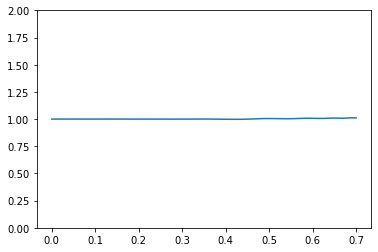

In [ ]:
plt.plot(t, As/A0)
plt.ylim([0, 2])

[<matplotlib.lines.Line2D>]

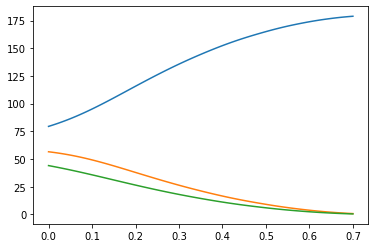

In [ ]:
plt.plot(t, angles[0])
plt.plot(t, angles[1])
plt.plot(t, angles[2])

In [ ]:
## naive Euler stepping - looks ok!

Ts = [y0,]
ts = [0,]

dt = .01

for i in range(70):
    ts.append(ts[-1]+dt)
    T_new = Ts[-1]+dt*excitable_dt(Ts[-1], m=2)
    Ts.append(T_new)
Ts = np.stack(Ts, axis=-1)
ts = np.array(ts)

[<matplotlib.lines.Line2D>]

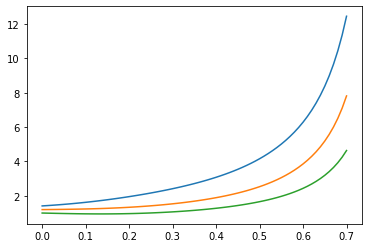

In [ ]:
plt.plot(ts, Ts[0])
plt.plot(ts, Ts[1])
plt.plot(ts, Ts[2])

## Create a test Half edge mesh and add a method to calculate internal angles

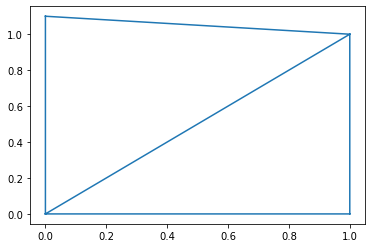

In [ ]:
test_hemesh = get_test_hemesh()

test_hemesh.triplot()

In [ ]:
#| export

@patch
def get_angles(self: HalfEdgeMesh):
    angle_dict = {}
    egde_lengths = self.get_edge_lens()
    for fc in self.faces.values():
        lengths = []
        heids = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            heids.append(he._heid)
            lengths.append(egde_lengths[he._heid])
            he = he.nxt
            returned = (he == start_he)
        angles = sides_angles(lengths) 
        for heid, a in zip(heids, angles):
            angle_dict[heid] = a   
    return angle_dict

@patch
def get_double_angles(self: HalfEdgeMesh):
    angles = self.get_angles()
    double_angles = {he._heid: (angles[he._heid]+angles[he._twinid]) for he in self.hes.values()
                             if (he.face is not None) and (he.twin.face is not None)}
    return double_angles

In [ ]:
test_hemesh.get_double_angles()

{2: 3.0419240010986313, 3: 3.0419240010986313}

## Optimize vertex positions given rest lengths

In [ ]:
## define function to measure energy = sum_edges (l_e -l_e,0)^2
# needs to take in a vector of vertex positions of shape (n)

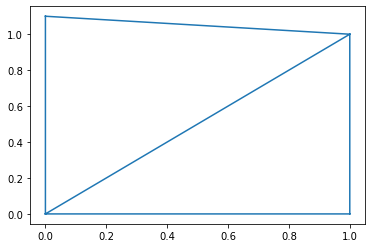

In [ ]:
mesh = get_test_hemesh()
mesh.triplot()

In [ ]:
# create a test vector

for he in mesh.hes.values():
    he.rest = 1.5 # for testing purposes

In [ ]:
# step 0: prepare initial condition. will serve as test vector. sort vectors by keys.

vertex_keys = sorted(mesh.vertices.keys())
vertex_vector = np.stack([mesh.vertices[key].coords for key in vertex_keys]).T

# scipy otpmize needs a 1d array. so stack x coords on top of y coords
x0 = np.hstack([vertex_vector[0], vertex_vector[1]])

In [ ]:
#%%time

# step 1: create a list of initial & terminal edge vertices. this will be used to calculate differences
# also create a reference vector of 

e_lst = []
rest_lengths = []

# we will need to look up which vertex key corresponds to list position
vertex_key_dict = {key: ix for ix, key in enumerate(sorted(mesh.vertices.keys()))}

for e in mesh.hes.values():
    if e._verticesid[0] < e._verticesid[1]: # avoid duplicates
        e_lst.append([vertex_key_dict[v._vid] for v in e.vertices])
        rest_lengths.append((e.rest+e.twin.rest)/2)
        
e_lst = np.array(e_lst).T
rest_lengths = np.array(rest_lengths)

# step 2 split up the vector and calculate lengths

x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
print((x[e_lst[0]]-x[e_lst[1]]), (y[e_lst[0]]-y[e_lst[1]]))  # looks good
lengths = sqrt((x[e_lst[0]]-x[e_lst[1]])**2 + (y[e_lst[0]]-y[e_lst[1]])**2)

E = 1/2 * (lengths-rest_lengths)**2

# it is much much faster to create these structures once only. 

[-1.  0. -1. -1.  0.] [ 0.  -1.  -1.   0.1 -1.1]


In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

from scipy.sparse import csc_matrix

In [ ]:
#| export

@patch
def vertices_to_initial_cond(self: HalfEdgeMesh):
    """Format vertices for use in energy minimization."""
    vertex_keys = sorted(self.vertices.keys())
    vertex_vector = np.stack([self.vertices[key].coords for key in vertex_keys]).T
    return np.hstack([vertex_vector[0], vertex_vector[1]])
       
@patch
def initial_cond_to_vertices(self: HalfEdgeMesh, x0):
    """Reverse of format vertices for use in energy minimization."""
    vertex_keys = sorted(self.vertices.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(vertex_keys, vertex_vector)}

def tri_area(x, y):
    """Shape (3, ...)"""
    return anp.sum(x*anp.roll(y, 1, axis=0) - anp.roll(x, 1, axis=0)*y, axis=0)/2

@patch
def get_energy_fct(self: HalfEdgeMesh, A0=sqrt(3)/4, reg_A=0):
    """Get energy function sum_edges (l_e -l_e,0)^2. remove translation mode by keeping COM fixed.
    Added regularization by fixing triangle areas. Reference [1,1,1] has area sqrt(3)/4
    """
    e_lst = []
    tri_lst = []
    rest_lengths = []

    # we will need to look up which vertex key corresponds to list position
    vertex_key_dict = {key: ix for ix, key in enumerate(sorted(self.vertices.keys()))}
    
    for e in self.hes.values():
        if e.duplicate: # avoid duplicates
            e_lst.append([vertex_key_dict[v._vid] for v in e.vertices])
            rest_lengths.append((e.rest+e.twin.rest)/2)
    e_lst = anp.array(e_lst).T
    rest_lengths = anp.array(rest_lengths)
    
    for fc in self.faces.values():
        tri_lst.append([vertex_key_dict[he.vertices[0]._vid] for he in fc.hes])
    tri_lst = anp.array(tri_lst).T
    
    center = anp.mean([val.coords for val in self.vertices.values()], axis=0)
    n_vertices = len(self.vertices)
    if reg_A == 0:
        def get_E(x0):
            x, y = (x0[:n_vertices], x0[n_vertices:])
            lengths = anp.sqrt((x[e_lst[0]]
                                -x[e_lst[1]])**2
                               + (y[e_lst[0]]-y[e_lst[1]])**2)
            E = 1/2 * anp.sum((lengths-rest_lengths)**2)  # normalize by rest length??
            # displacement from initial center
            E = E + 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
            return E
    else:
        def get_E(x0):
            x, y = (x0[:n_vertices], x0[n_vertices:])
            lengths = anp.sqrt((x[e_lst[0]]
                                -x[e_lst[1]])**2
                               + (y[e_lst[0]]-y[e_lst[1]])**2)
            E = 1/2 * anp.sum((lengths-rest_lengths)**2)
            # triangle area penalty
            A = anp.abs(tri_area(x[tri_lst], y[tri_lst]))
            #E = E + reg_A/2 * anp.sum((A-A0)**2)
            
            E = E + reg_A * anp.sum(1/2 * A**2 + A0**3 * (1/A))
            
            # displacement from initial center
            E = E + 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
            return E
    return get_E, agrad(get_E)

# should replace sum by mean -might break stuff, e.g. optimizer tolerances
# also: might make things scale invariant, e.g. divide by lengths.

<matplotlib.collections.LineCollection>

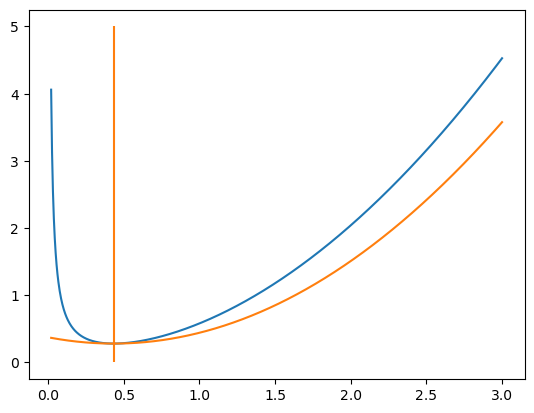

In [ ]:
A0 = sqrt(3)/4

As = np.linspace(.02, 3, 1000)

V_A1 = 1/2 * As**2 + A0**3 * (1/As)
V_A2 = 1/2 * (As-A0)**2 #+ .01 * (1/As)


plt.plot(As, V_A1)
plt.plot(As, V_A2+(V_A1-V_A2).min())



plt.vlines(A0, 0, 5, color='tab:orange')

In [ ]:
A0**3

0.08118988160479111


$$
V(A) = \frac{c_1}{2} A^2 + c_2 A^{-1} \\
\partial_A V(A) = c_1 A - c_2 A^{-2} \\
\text{minimum at: } A^3 =   c_2/c_1
$$

Fix $c_1=1$


In [ ]:
A0

0.4330127018922193

In [ ]:
# to do: add area elasticity term to remove bad configurations where a triangle collapses.

In [ ]:
test_hemesh_large = get_test_hemesh_large()
x0 = test_hemesh_large.vertices_to_initial_cond()

In [ ]:
get_E, jac = test_hemesh_large.get_energy_fct(reg_A=.1)

In [ ]:
get_E(x0)

24.589442230200312

In [ ]:
test_hemesh_large = get_test_hemesh_large()

x0 = test_hemesh_large.vertices_to_initial_cond()
get_E, jac = test_hemesh_large.get_energy_fct()

In [ ]:
#| notest

%timeit get_E(x0)
# pretty fast.

65.1 µs ± 3.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
#| notest

%timeit jac(x0)
# autograd: 3ms

2.84 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
test_hemesh = get_test_hemesh()

for he in test_hemesh.hes.values():
    he.rest = 1.5 # for testing purposes

In [ ]:
print(test_hemesh.initial_cond_to_vertices(test_hemesh.vertices_to_initial_cond()))
print({key: val.coords for key, val in test_hemesh.vertices.items()})
# looks good

{0: array([0., 0.]), 1: array([0. , 1.1]), 2: array([1., 0.]), 3: array([1., 1.])}
{0: array([0., 0.]), 1: array([0. , 1.1]), 2: array([1., 0.]), 3: array([1., 1.])}


## now let's try to minimize!

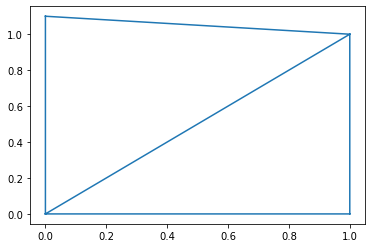

In [ ]:
# create a test case

mesh = get_test_hemesh()
for he in mesh.hes.values():
    he.rest = 1.5 # for testing purposes
mesh.triplot()

In [ ]:
%%time
x0 = mesh.vertices_to_initial_cond()
get_E, grd = mesh.get_energy_fct()

sol = optimize.minimize(get_E, x0, method="BFGS", jac=agrad(get_E))

print(sol["message"])
new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
for key, val in mesh.vertices.items():
    val.coords = new_coord_dict[key]

Optimization terminated successfully.
CPU times: user 48.3 ms, sys: 0 ns, total: 48.3 ms
Wall time: 17.9 ms


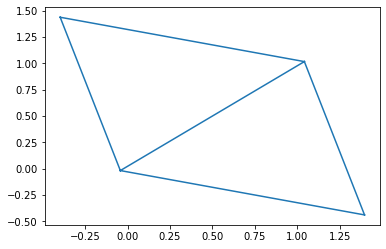

In [ ]:
mesh.triplot()

### Try a larger mesh

The pre-optimization routine I wrote is not necessary in practice and has been deleted

In [ ]:
# try a more difficult task - larger mesh

test_hemesh_large = get_test_hemesh_large()

edge_lengths = test_hemesh_large.get_edge_lens()
for e, val in edge_lengths.items():
    test_hemesh_large.hes[e].rest = val + np.random.normal(scale=1e-2)
    #mesh.hes[e].rest = 1.01*val

In [ ]:
%%time

# pre-optimizing improves energy by 2x in 250ms

get_E, grd = test_hemesh_large.get_energy_fct()
x0 = test_hemesh_large.vertices_to_initial_cond()
print(get_E(x0))

0.09034822215769824
CPU times: user 69.7 ms, sys: 0 ns, total: 69.7 ms
Wall time: 69.8 ms


In [ ]:
# how fast is optimization with scipy?

test_hemesh_large = get_test_hemesh_large()

edge_lengths = test_hemesh_large.get_edge_lens()
for e, val in edge_lengths.items():
    test_hemesh_large.hes[e].rest = val + np.random.normal(scale=0.001)
    #mesh.hes[e].rest = 1.01*val
get_E, grd = test_hemesh_large.get_energy_fct()
x0 = test_hemesh_large.vertices_to_initial_cond()
get_E(x0)

0.0009034867707847972

In [ ]:
# BFGS is slow, but CG and Newton-CG are pretty fast!

In [ ]:
#| notest
%time sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
print(sol["message"])
get_E(x0) / get_E(sol["x"])

CPU times: user 5.63 s, sys: 546 ms, total: 6.17 s
Wall time: 1.71 s
Optimization terminated successfully.


3.0202882747151483

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, method="CG", jac=grd, tol=1e-3)
print(sol["message"])
get_E(x0) / get_E(sol["x"])

Optimization terminated successfully.
CPU times: user 34.2 ms, sys: 0 ns, total: 34.2 ms
Wall time: 33.9 ms


3.0202881760828575

In [ ]:
%%time
sol = optimize.minimize(get_E, x0, method="Newton-CG", jac=grd, tol=1e-4)
print(sol["message"])
get_E(x0) / get_E(sol["x"])

Optimization terminated successfully.
CPU times: user 626 ms, sys: 0 ns, total: 626 ms
Wall time: 627 ms


3.4215437914064326

In [ ]:
# | notest

%time sol = optimize.minimize(get_E, x0, method="BFGS", tol=1e-3)
print(sol["message"])
get_E(x0) / get_E(sol["x"])

# without the gradient

CPU times: user 8.57 s, sys: 1.12 s, total: 9.7 s
Wall time: 4.15 s
Optimization terminated successfully.


3.020287638027295

In [ ]:
## finally, this is how you re-set the coordinate values

new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
for key, val in mesh.vertices.items():
    val.coords = new_coord_dict[key]

## Euler step for whole triangulation

In [ ]:
mesh = get_test_hemesh()
mesh.set_rest_lengths()

[val.hes for val in mesh.faces.values()]

[[HalfEdge(heid=0, nxt=1, prev=2, twin=6, face=0, vertices=(0, 2), rest=1.0, passive=0.0, center=[0.5 0. ],
  HalfEdge(heid=1, nxt=2, prev=0, twin=7, face=0, vertices=(2, 3), rest=1.0, passive=0.0, center=[1.  0.5],
  HalfEdge(heid=2, nxt=0, prev=1, twin=3, face=0, vertices=(3, 0), rest=1.4, passive=0.0, center=[0.5 0.5]],
 [HalfEdge(heid=3, nxt=4, prev=5, twin=2, face=1, vertices=(0, 3), rest=1.4, passive=0.0, center=[0.5 0.5],
  HalfEdge(heid=4, nxt=5, prev=3, twin=8, face=1, vertices=(3, 1), rest=1.0, passive=0.0, center=[0.5 1. ],
  HalfEdge(heid=5, nxt=3, prev=4, twin=9, face=1, vertices=(1, 0), rest=1.1, passive=0.0, center=[0.  0.6]]]

In [ ]:
%%time

# using the fact that the list of faces in a mesh should now be correctly oriented, let's Euler step 
# all the rest lengths of a mesh (as long as they are not None)

m = 2
dt = .01

for fc in mesh.faces.values():
    # collect edges
    Ts = np.array([he.rest for he in fc.hes])
    Ts += dt*excitable_dt(Ts, m=2)
    for T, he in zip(Ts, fc.hes):
        he.rest = T

CPU times: user 2.82 ms, sys: 0 ns, total: 2.82 ms
Wall time: 1.88 ms


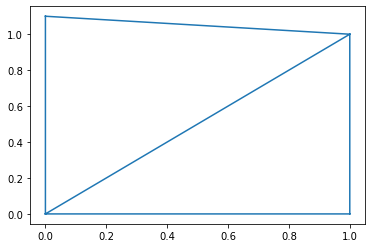

In [ ]:
mesh = get_test_hemesh()
mesh.set_rest_lengths()
mesh.triplot()

In [ ]:
%%time

# now let"s try a full loop with optimization

m = 2
dt = .01

for i in range(25):
    # euler step
    mesh.set_rest_lengths()
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="CG", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print(sol["message"])
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()

CPU times: user 198 ms, sys: 3.86 ms, total: 202 ms
Wall time: 201 ms


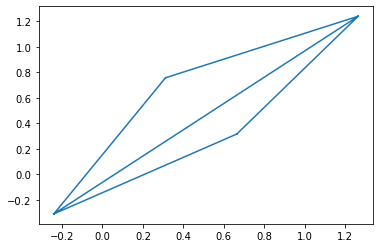

In [ ]:
mesh.triplot()

(-0.35000000000000003, 7.35, -0.35000000000000003, 7.35)

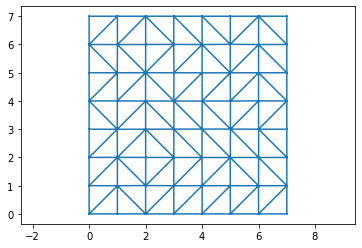

In [ ]:
## and now with a larger mesh

mesh = get_test_hemesh_large(x=np.arange(8.), y=np.arange(8.))
mesh.set_rest_lengths()
mesh.is_consistent()

mesh.triplot()
plt.axis("equal")

In [ ]:
%%time

# now let"s try a full loop with optimization

m = 2
dt = .01

for i in range(20):
    mesh.set_rest_lengths()
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="CG", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print(sol["message"])
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
        

CPU times: user 911 ms, sys: 0 ns, total: 911 ms
Wall time: 914 ms


(-0.9803253560452555,
 8.24090847708847,
 -0.9262429842565462,
 7.9787057842264035)

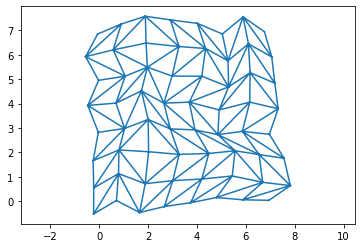

In [ ]:
mesh.triplot()
plt.axis("equal")

## Simulation with edge flips

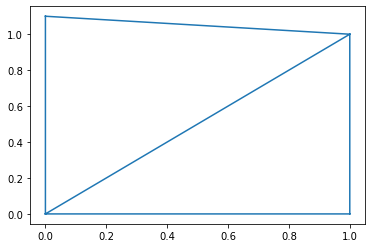

In [ ]:
mesh = get_test_hemesh()
mesh.set_rest_lengths()

mesh.triplot()
plt.show()

In [ ]:
%%time

# now let"s try a full loop with optimization

m = 2
dt = .001


meshes = [mesh]
times = [0]

for i in range(600):
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts = np.array([he.rest for he in fc.hes])
        Ts += dt*excitable_dt(Ts, m=2)
        for T, he in zip(Ts, fc.hes):
            he.rest = T
    # flatten
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="CG", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print(sol["message"])
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
    # compute angles and carry out an edge flip if required
    angles = mesh.get_angles()
    argmax = max(angles, key=angles.get)
    if angles[argmax] > 130 * (pi/180):
        print("flip")
        mesh.triplot()
        plt.title("pre")
        plt.show()
        
        mesh.flip_edge(argmax)
        mesh.set_rest_lengths()

        mesh.triplot()
        plt.title("post")
        plt.show()

    plt.show()
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 1.4 s


## code for handling "passive" tension post 

In [ ]:
#| export

def excitable_dt_post(Ts, Tps, k=1, m=2):
    """Time derivative of tensions under excitable tension model with constrained area,
    with passive tension for post intercalation"""
    dT_dt = (Ts-Tps)**m - k*Tps
    dTp_dt = -k*Tps
    area_jac = sides_area_jac(Ts-Tps)
    area_jac /= norm(area_jac)
    dT_dt -= area_jac * (area_jac@dT_dt)
    return dT_dt, dTp_dt

@patch
def reset_rest_passive_flip(self: HalfEdgeMesh, e: HalfEdge, method="smooth"):
    """Reset rest length and passive tensions of flipped he according to myosin inheritance.
    Two options: "smooth" results in contiuous rest lengths, using the passive contruction,
    "direct" directly sets the rest length to the values of the neighbors.
    """
    twin = e.twin
    rest_pre = (e.rest+twin.rest)/2
    rest_neighbors = (e.nxt.rest+e.prev.rest+twin.nxt.rest+twin.prev.rest)/4
    if method == "smooth":
        e.rest = np.linalg.norm(e.vertices[0].coords - e.vertices[1].coords)
        e.passive = (rest_pre+e.rest)-2*rest_neighbors
        twin.rest, twin.passive = (e.rest, e.passive)
    elif method == "direct":
        e.rest = rest_neighbors
        e.passive = rest_pre-rest_neighbors
        twin.rest, twin.passive = (e.rest, e.passive)
    else:
        print("method must be smooth or direct")

In [ ]:
mesh = get_test_hemesh()

mesh.vertices[1].coords = np.array([-.3, 1.3])
mesh.vertices[2].coords = np.array([1.2, -.4])
mesh.set_rest_lengths()

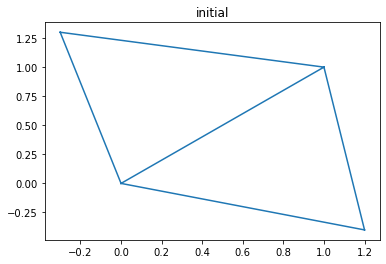

flip


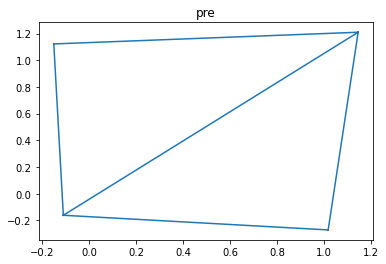

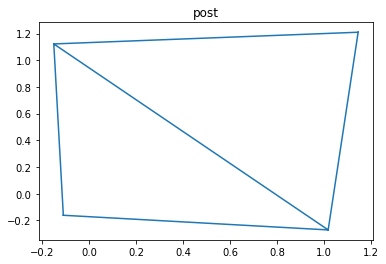

flip


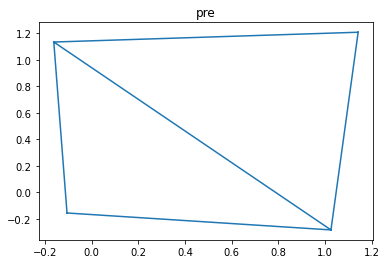

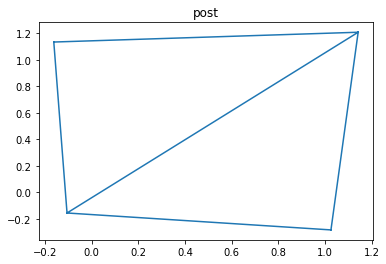

flip


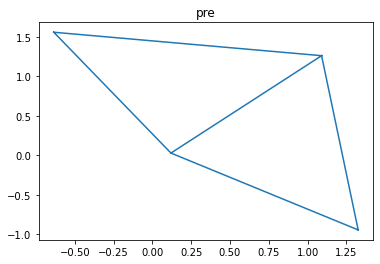

CPU times: user 2.05 s, sys: 608 ms, total: 2.66 s
Wall time: 1.43 s


In [ ]:
%%time

# as expected, without resetting data post intercalation, there are never ending forward-backward flipes

m = 2
dt = .01

meshes = [mesh]
times = [0]

mesh.triplot()
plt.title("initial")
plt.show()

for i in range(80):
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        dT_dt, dTp_dt = excitable_dt_post(Ts, Tps, k=1, m=2)
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
    # flatten
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print(sol["message"])
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
    # compute angles and carry out an edge flip if required
    angles = mesh.get_angles()
    argmax = max(angles, key=angles.get)
    if angles[argmax] > 90 * (pi/180):
        print("flip")
        mesh.triplot()
        plt.title("pre")
        plt.show()
        
        # resetting the active and passive tensions
        mesh.reset_rest_passive_flip(mesh.hes[argmax])
        try:
            mesh.flip_edge(argmax)
        except ValueError:
            break
        
        mesh.triplot()
        plt.title("post")
        plt.show()

    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

## Mesh plot with colored edges

Can also be done more efficiently with LineCollection

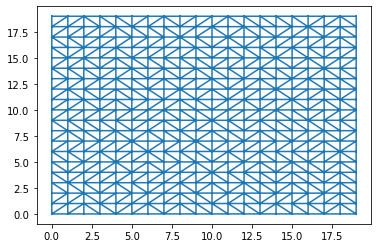

In [ ]:
mesh = get_test_hemesh_large(x=np.arange(20.), y=np.arange(20.))
mesh.set_rest_lengths()
mesh.triplot()

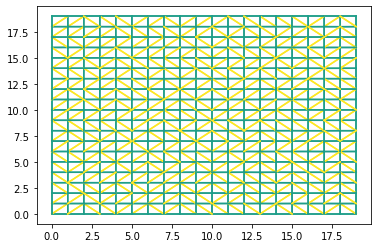

In [ ]:
#| notest
vmin, vmax = (.5, 1.4)
rescale = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap =  mpl.colormaps['viridis']

color_by = mesh.get_edge_lens()

for key, he in mesh.hes.items():
    line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
    plt.plot(*line.T, c=cmap(rescale(color_by[key])))


## Export code

In [ ]:
#| hide
nbdev.nbdev_export()